In [36]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import plotly.offline as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)

## Реалізація МНКО

In [67]:
def RMNK(X, y, s=None, sigma_estimation=None, verbose=False,
         deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, sigma_estimation,
                                     verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, sigma_estimation,
                                 verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            if sigma_estimation is None:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
            else:
                df = pd.DataFrame(columns=['s', 'RSS', 'Cp_simple',
                                           'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        Cp_simple = RSS_next + 2 * m
        if sigma_estimation is None:
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp': Cp_simple, 'FPE': FPE},
                           ignore_index=True)
        else:
            Cp = RSS_next + 2 * sigma_estimation * m
            df = df.append({'s': m, 'RSS': RSS_next,
                            'Cp_simple': Cp_simple,
                            'Cp': Cp, 'FPE': FPE},
                           ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace - \enspace різниця\:вперед$
### $N'(t)≈ N(t)-N(t-1) \enspace - \enspace різниця\:назад$
### $N'(t)≈ \frac{N(t+1)-N(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $Розглядатимемо\: для\: різниці\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1\\
                  θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
### $ \Rightarrow \left \{ \begin{array}{ll}
                  μ = -θ_2 \\
                  k = (1 - θ_1) / θ_2
                \end{array}
              \right. $

In [48]:
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\t\
               k = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
        
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['N(t)'],
            y=self.df['N^2(t)'],
            z=self.df['N(t+1)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')
        
    def run_single_RMNK(self, verbose=True, deep_verbose=True):
        print('Recurrent Least Squares Method')
        self.theta_pred = RMNK(self.X, self.y, verbose=verbose, deep_verbose=deep_verbose)[0][:,0]
        self.μ_pred, self.k_pred = self.inter_to_init_params(*self.theta_pred)
        print('=============================================')
        print('\nINTERMEDIATE PARAMETERS')
        print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
        print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*self.theta_pred))
        print('\nINITIAL PARAMETERS')
        print('True values:\tμ = {}\tk = {}'.format(self.μ, self.k))
        print('Estimates:\tμ* = {}\tk* = {}'.format(self.μ_pred, self.k_pred))
        plt.scatter(self.t, self.y)
        t_for_plot = np.linspace(self.t_start, self.t_end,
                                 num=self.num_samples * 10)
        plt.plot(t_for_plot, odeint(Verhulst_model_equation, self.N0, t_for_plot,
                                    (self.μ_pred, self.k_pred)), 'r')
        plt.show()
        
    def run_grid_RMNK(self, verbose=False):
        intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                          'θ_1', 'θ_1*',
                                                          'θ_2', 'θ_2*'])
        initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                     'μ', 'μ*', 'k', 'k*'])
        for C in self.C_grid:
            for num_samples in self.num_samples_grid: 
                self.recompile(C, num_samples)
                theta_pred = RMNK(self.X, self.y, verbose=False)[0][:,0]
                μ_pred, k_pred = self.inter_to_init_params(*theta_pred)
                intermediate_estimates_df = \
                intermediate_estimates_df.append({'C': self.C,
                                                  'num_samples': self.num_samples,
                                                  'θ_1': self.theta[0],
                                                  'θ_1*': theta_pred[0],
                                                  'θ_2': self.theta[1],
                                                  'θ_2*': theta_pred[1]},
                                                 ignore_index=True)
                initial_estimates_df = \
                initial_estimates_df.append({'C': self.C,
                                             'num_samples': self.num_samples,
                                             'μ': self.μ,
                                             'μ*': μ_pred,
                                             'k': self.k,
                                             'k*': k_pred},
                                             ignore_index=True)
                if verbose:
                    print('=============================================================')
                    print('C: {}\t num_samples: {}'.format(self.C,
                                                           self.num_samples))
                    print('\nINTERMEDIATE PARAMETERS')
                    print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
                    print('\nINITIAL PARAMETERS')
                    print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))

#         print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
#         print('True init.  params values:\tμ = {}\tk = {}'.format(self.μ, float(self.k)))
        return pd.concat([intermediate_estimates_df,
                          initial_estimates_df[['μ', 'μ*', 'k', 'k*']]],
                         axis=1)

Initial parameters:	μ = 0.0001
			               k = 100
			N0 = 10

Noise generation: C = 3
Sample length: n = 50
Time starting from 0 to 500                with discretization frequency 10



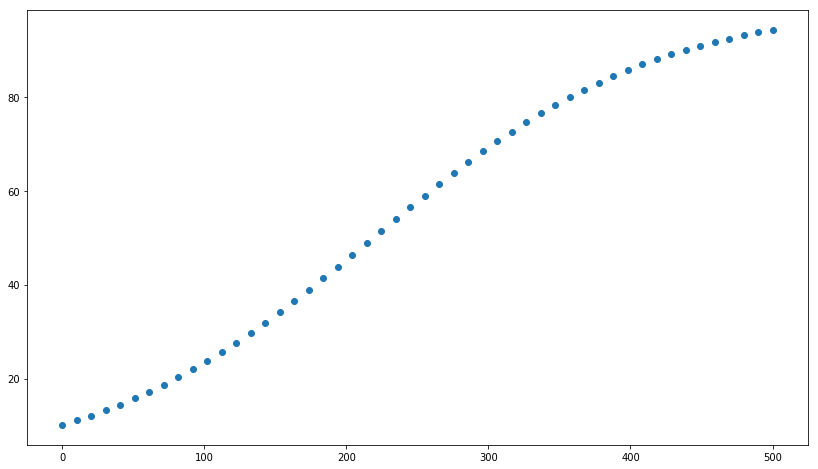

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [49]:
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

In [50]:
# config.plot_3D()

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
> RSS_1: 0.5984206103312317
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[[59837637.56477976]]
gamma_2:	14893552.797599493
nu_2:		[[-0.0001]]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]
> RSS_2: 3.305702054645643e-06

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189032	θ_2* = -0.00010000341994463542

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994463542	k* = 99.99101055183083


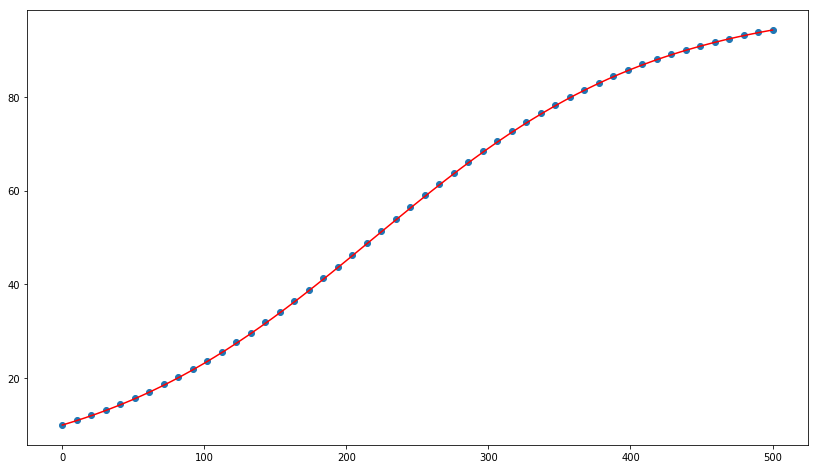

In [51]:
config.run_single_RMNK(verbose=True, deep_verbose=True)

In [53]:
config.run_grid_RMNK(verbose=False)

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,μ,μ*,k,k*
0,0.0,10.0,1.01,0.998957,-0.0001,0.000044,0.0001,-0.000044,100.0,23.826999
1,0.0,50.0,1.01,1.010265,-0.0001,-0.000106,0.0001,0.000106,100.0,96.768521
2,0.0,100.0,1.01,1.009688,-0.0001,-0.000097,0.0001,0.000097,100.0,100.083587
3,2.0,10.0,1.01,1.009857,-0.0001,-0.000098,0.0001,0.000098,100.0,100.559471
4,2.0,50.0,1.01,1.009994,-0.0001,-0.000100,0.0001,0.000100,100.0,100.105598
5,2.0,100.0,1.01,1.009956,-0.0001,-0.000099,0.0001,0.000099,100.0,100.113571
6,5.0,10.0,1.01,1.010000,-0.0001,-0.000100,0.0001,0.000100,100.0,100.000233
7,5.0,50.0,1.01,1.010000,-0.0001,-0.000100,0.0001,0.000100,100.0,100.000141
8,5.0,100.0,1.01,1.010000,-0.0001,-0.000100,0.0001,0.000100,100.0,100.000091


---

## 2. Рівняння згасаючих коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t) \enspace - \enspace різниця\:вперед$
### $x'(t)≈ x(t)-x(t-1) \enspace - \enspace різниця\:назад$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $Розглянемо\: для\: апроксимації\: різницею\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}\\
                  θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

In [54]:
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        

class OscillationModelConfig(): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]

    def __init__(self, difference='forward'):
        self.difference = difference
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation,
                        np.array([self.x0, self.x00]),
                        self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation,
                          np.array([self.x1, self.x11]), self.t+1,
                          (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr,
                                                        self.x0, self.x00))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        if self.difference == 'center':
            divider = 1 + self.δ
            w1 = (2 - self.ω0_sqr) / divider
            w2 = - (1 - self.δ) / divider
        elif self.difference == 'forward':
            divider = 1 + 2 * self.δ
            w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
            w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        if self.difference == 'center':
            δ = (1 + w2) / (1 - w2)
            ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        elif self.difference == 'forward':
            δ = - (1 / w2 + 1) / 2
            ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
    
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['x(t)'],
            y=self.df['x(t+1)'],
            z=self.df['x(t+2)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')

    def run_single_RMNK(self, verbose=True, deep_verbose=False):
        print('Recurrent Least Squares Method')
        self.theta_pred = RMNK(self.X, self.y, verbose=verbose, deep_verbose=deep_verbose)[0][:,0]
        self.δ_pred, self.ω0_sqr_pred = self.inter_to_init_params(*self.theta_pred)
        print('=============================================')
        print('\nINTERMEDIATE PARAMETERS')
        print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
        print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*self.theta_pred))
        print('\nINITIAL PARAMETERS')
        print('True values:\tδ = {}\t\t\tω0^2 = {}'.format(self.δ, self.ω0_sqr))
        print('Estimates:\tδ* = {}\tω0^2* = {}'.format(self.δ_pred, self.ω0_sqr_pred))
        plt.scatter(self.t, self.y)
        t_for_plot = np.linspace(self.t_start, self.t_end,
                                 num=self.num_samples * 10)
        plt.plot(t_for_plot, odeint(Oscillation_model_equation, 
                                    np.array([self.x0, self.x00]),
                                    t_for_plot,
                                    (self.δ_pred, self.ω0_sqr_pred))[:,0], 'r')
        plt.show()
        
    def run_grid_RMNK(self, verbose=True):
        intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                          'θ_1', 'θ_1*',
                                                          'θ_2', 'θ_2*'])
        initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                     'δ', 'δ*',
                                                     'ω0_sqr', 'ω0_sqr*'])
        for C in self.C_grid:
            for num_samples in self.num_samples_grid: 
                self.recompile(C, num_samples)
                intermediate_estimates_df
                theta_pred = RMNK(self.X, self.y, verbose=False)[0][:,0]
                δ_pred, ω0_sqr_pred = self.inter_to_init_params(*theta_pred)
                intermediate_estimates_df = \
                intermediate_estimates_df.append({'C': self.C,
                                                  'num_samples': self.num_samples,
                                                  'θ_1': self.theta[0],
                                                  'θ_1*': theta_pred[0],
                                                  'θ_2': self.theta[1],
                                                  'θ_2*': theta_pred[1]},
                                                 ignore_index=True)
                initial_estimates_df = \
                initial_estimates_df.append({'C': self.C,
                                             'num_samples': self.num_samples,
                                             'δ': self.δ,
                                             'δ*': δ_pred,
                                             'ω0_sqr': self.ω0_sqr,
                                             'ω0_sqr*': ω0_sqr_pred},
                                             ignore_index=True)
                if verbose:
                    print('=============================================================')
                    print('C: {}\t num_samples: {}'.format(self.C, self.num_samples))
                    print('\nINTERMEDIATE PARAMETERS')
                    print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
                    print('\nINITIAL PARAMETERS')
                    print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred,
                                                                            ω0_sqr_pred))

#         print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
#         print('True init.  params values:\tδ = {}\t\t\tω0^2 = {}'.format(self.δ, self.ω0_sqr))
        return pd.concat([intermediate_estimates_df,
                          initial_estimates_df[['δ', 'δ*', \
                                                'ω0_sqr', 'ω0_sqr*']]],
                         axis=1)

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



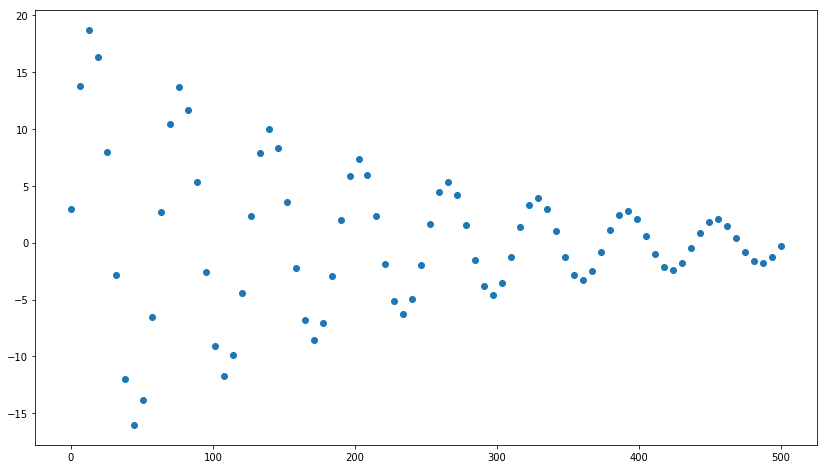

Intermediate parameters values: θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Regression model: y = (1.98019801980198) * x1 + (-0.9900990099009901) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [55]:
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

In [56]:
# config.plot_3D()

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.3120437748094
nu_1:		[0.95802084]
> θ_1: [0.95802084]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.453858680092708
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.298727481169
nu_2:		[[-0.99045368]]
> θ_2: [ 1.98062616 -0.99045368]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006414646978853966

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Estimates:	θ_1* = 1.9806261560117373	θ_2* = -0.9904536768605925

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004819166894137972	ω0^2* = 0.009922241775107699


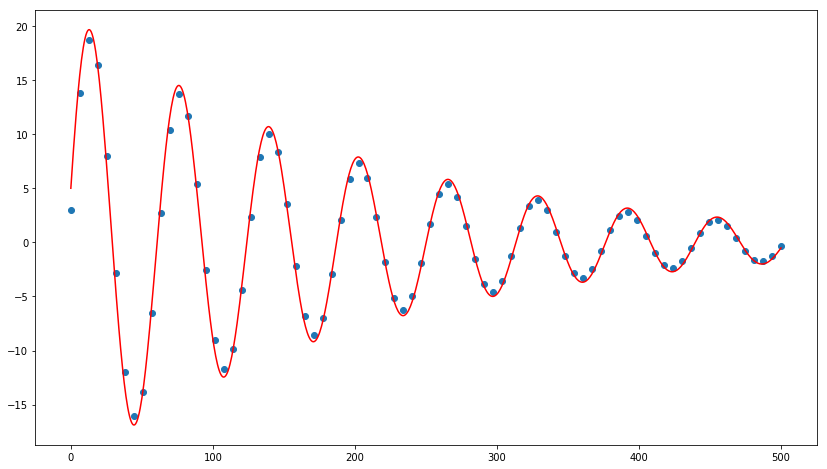

In [57]:
config.run_single_RMNK(verbose=True, deep_verbose=True)

In [58]:
forward_df = config.run_grid_RMNK(verbose=False)
forward_df

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*
0,0.0,30.0,1.980198,2.092809,-0.990099,-1.100300,0.005,-0.045579,0.01,0.006809
1,0.0,80.0,1.980198,1.959643,-0.990099,-0.966105,0.005,0.017542,0.01,0.006689
2,0.0,150.0,1.980198,1.985392,-0.990099,-0.991847,0.005,0.004110,0.01,0.006507
3,2.0,30.0,1.980198,1.980402,-0.990099,-0.990257,0.005,0.004919,0.01,0.009952
4,2.0,80.0,1.980198,1.980626,-0.990099,-0.990454,0.005,0.004819,0.01,0.009922
5,2.0,150.0,1.980198,1.980007,-0.990099,-0.989910,0.005,0.005096,0.01,0.010005
6,5.0,30.0,1.980198,1.980197,-0.990099,-0.990098,0.005,0.005001,0.01,0.010000
7,5.0,80.0,1.980198,1.980199,-0.990099,-0.990100,0.005,0.005000,0.01,0.010000
8,5.0,150.0,1.980198,1.980197,-0.990099,-0.990098,0.005,0.005000,0.01,0.010000


### $Розглянемо\: для\: апроксимації\: центральною\: різницею:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+δ[x(t+1)-x(t-1)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2-ω_0^2}{1+δ}x(t+1)-\frac{1-δ}{1+δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2-ω_0^2}{1+δ}\\
                  θ_2 = -\frac{1-δ}{1+δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



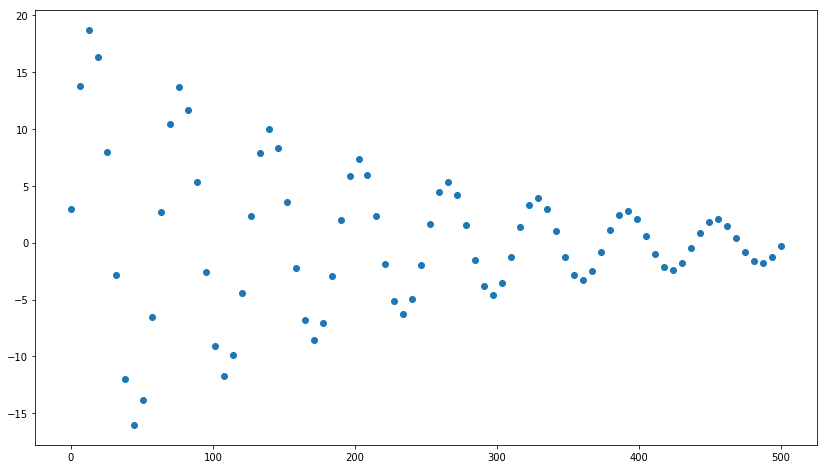

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [59]:
config = OscillationModelConfig(difference='center')
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.447942916061038
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.266809326686
nu_2:		[[-0.99035405]]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006504761399703796

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.980513626457381	θ_2* = -0.9903540525860997

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004846347513582927	ω0^2* = 0.009888116253420117


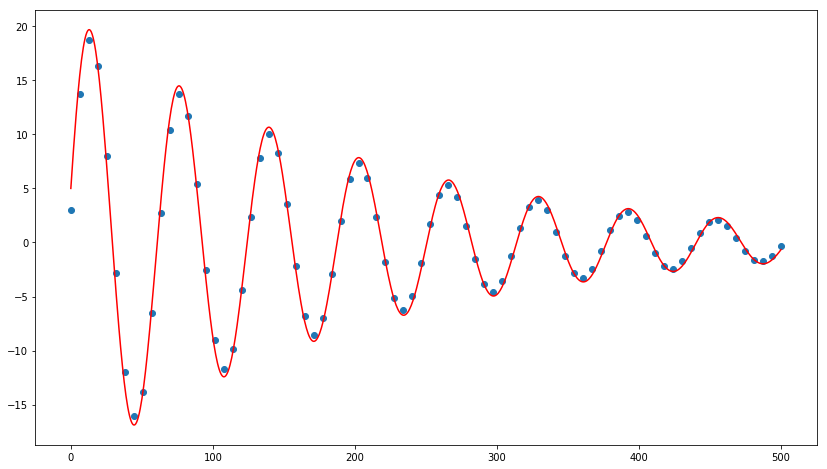

In [60]:
config.run_single_RMNK(verbose=True, deep_verbose=True)

In [61]:
center_df = config.run_grid_RMNK(verbose=False)
center_df

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*
0,0.0,30.0,1.9801,2.092809,-0.99005,-1.100300,0.005,-0.047755,0.01,0.007134
1,0.0,80.0,1.9801,1.959643,-0.99005,-0.966105,0.005,0.017240,0.01,0.006574
2,0.0,150.0,1.9801,1.985392,-0.99005,-0.991847,0.005,0.004093,0.01,0.006481
3,2.0,30.0,1.9801,1.980023,-0.99005,-0.989908,0.005,0.005071,0.01,0.009935
4,2.0,80.0,1.9801,1.980514,-0.99005,-0.990354,0.005,0.004846,0.01,0.009888
5,2.0,150.0,1.9801,1.979936,-0.99005,-0.989861,0.005,0.005095,0.01,0.009975
6,5.0,30.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
7,5.0,80.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
8,5.0,150.0,1.9801,1.980100,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000


In [62]:
center_df['difference'] = 'center'
forward_df['difference'] = 'forward'
pd.concat([center_df, forward_df], axis=0).sort_values(by=['C',
                                                           'num_samples',
                                                           'difference'])

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*,difference
0,0.0,30.0,1.980100,2.092809,-0.990050,-1.100300,0.005,-0.047755,0.01,0.007134,center
0,0.0,30.0,1.980198,2.092809,-0.990099,-1.100300,0.005,-0.045579,0.01,0.006809,forward
1,0.0,80.0,1.980100,1.959643,-0.990050,-0.966105,0.005,0.017240,0.01,0.006574,center
1,0.0,80.0,1.980198,1.959643,-0.990099,-0.966105,0.005,0.017542,0.01,0.006689,forward
2,0.0,150.0,1.980100,1.985392,-0.990050,-0.991847,0.005,0.004093,0.01,0.006481,center
2,0.0,150.0,1.980198,1.985392,-0.990099,-0.991847,0.005,0.004110,0.01,0.006507,forward
3,2.0,30.0,1.980100,1.980023,-0.990050,-0.989908,0.005,0.005071,0.01,0.009935,center
3,2.0,30.0,1.980198,1.980402,-0.990099,-0.990257,0.005,0.004919,0.01,0.009952,forward
4,2.0,80.0,1.980100,1.980514,-0.990050,-0.990354,0.005,0.004846,0.01,0.009888,center
4,2.0,80.0,1.980198,1.980626,-0.990099,-0.990454,0.005,0.004819,0.01,0.009922,forward


## 3. Дослідження закономірностей задачі структурно параметричної ідентифікації 

Розглянемо настпуні критерії

$ RSS(s) $

RSS(s) (як функція дискретного аргумента s) є строго спадною. Тобто при підвищенні складності (число аргументів або регресорів) моделі, наприклад, за рахунок шумів, значення цієї функції зменшиться. Тому її не можна використовувати в якості критерія оптимальності моделі.

Тож введемо такі два критерії, які будемо використовувати для селекції оптимальних моделей

$ C_p(s) = RSS(s) + 2s - \text{спрощений критерій Меллоуза} $

$ FPE(s) = \frac{n + s}{n - s} RSS(s) - \text{критерій фінальної помилки передбачення Акаіке} $

In [276]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.01
    sigma_grid = [0.1, 0.5, 1]
    s = 5
    s_grid = [1, 2, 3, 4, 5]
    
    def __init__(self):
        self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self):
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def recompile(self, n, sigma):
        self.n = n
        self.sigma = sigma
        self.compile()
        
    def show(self):
#         print('Regressors: m = {}'.format(self.m))
#         print('True parameters: θ = {}'.format(self.theta))
        print('Sample length: n = {}'.format(self.n))
        print('Noise generation: σ = {}'.format(self.sigma))
        print('X[:10]:\n{}'.format(self.X[:10]))
        print('y[:10]:\n{}'.format(self.y[:10]))
        
    def show_estimations(self):
        print('RSS(m) = {:5.5}'.format(self.RSS))
        print('σ* = {:5.5}'.format(self.sigma_hat ** .2))
    
    def estimate_sigma(self):
        _, _, self.RSS = RMNK(self.X, self.y, s=self.s,
                         verbose=False, create_dataframe=False)
        self.sigma_hat = self.RSS ** 2 / (self.X.shape[0] - self.X.shape[1])
        
    def run_grid_RMNK_model_selection(self):
        self.estimate_sigma()
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.recompile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = RMNK(self.X, self.y, s=self.s,
                                            verbose=True, create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()
    
    def run_single_full_RMNK_model_selection(self, sort_values_by=['Cp', 'FPE']):
        total_df = pd.DataFrame()
        for p in permutations(range(self.X.shape[1])):
            p = np.array(p)
            theta_pred, _, _, df = RMNK(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            total_df = pd.concat([total_df, df], axis=0)

        total_df['RSS'] = np.round(total_df['RSS'], 6)
        total_df['Cp'] = np.round(total_df['Cp'], 6)
        total_df['FPE'] = np.round(total_df['FPE'], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=sort_values_by).reset_index()\
                   [['s', 'regressors', 'RSS', 'Cp', 'FPE']]
        return total_df

In [277]:
config = ModelConfig()

In [278]:
config.recompile(n=1000, sigma=0.1)
config.generate_noise_and_output()
config.show()

Sample length: n = 1000
Noise generation: σ = 0.1
X[:10]:
[[0.31837099 1.38438811 0.69678667 1.17077377 1.0818263 ]
 [1.59810633 0.56482391 0.11369135 0.11272838 0.61185166]
 [1.61827769 0.92966615 0.29478655 0.05408972 1.85260927]
 [0.88906526 1.86540116 1.42148837 0.3443173  1.91791228]
 [0.06670765 1.59161495 0.80338874 1.0026813  1.42621796]
 [1.62952532 1.75118855 0.60588994 1.35484081 0.38786323]
 [1.45869835 0.16003931 1.25132522 1.74480468 1.40397536]
 [0.02124602 0.87289449 1.61817423 1.88253723 1.06308919]
 [1.39911582 0.90054679 0.29792312 1.47089637 0.10520711]
 [1.08081649 1.92567895 0.23365078 0.41833254 0.52723218]]
y[:10]:
[-1.04835895  3.86321876  3.23333234  0.08162802 -2.0021241   2.19446906
  5.40984451 -0.01683494  2.83448791 -0.31689961]


--------------------------------------------------------------
			SAMPLE #1
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.1
X[:10]:
[[1.79514949 1.15317166 1.55251335 0.16529806 1.00307379]
 [0.33024554 1.13819052 1.03477886 1.82313754 0.09419123]
 [1.23241486 1.72538613 1.86249867 0.04402511 1.70796775]
 [0.26393573 0.14082194 0.70178489 0.56444701 1.29439949]
 [1.02329645 0.0957558  0.43489816 1.3559997  0.98033862]
 [0.36956374 1.83183019 0.19167246 1.29819154 1.76099147]
 [1.11280257 1.88637762 0.19786935 1.09433248 0.99666312]
 [1.27089813 0.42570521 1.06037731 1.93086663 0.64677235]
 [0.03347599 1.2576337  1.10858531 0.11820673 0.57219365]
 [1.1714321  0.39153269 0.71846003 1.87450705 1.09130563]]
y[:10]:
[ 4.67953784 -0.27488826  2.01721442  1.43590766  3.20366081 -2.34534175
 -0.30325807  4.19110807 -1.45402786  3.5660796 ]

		RLSM ITERATIONS
	Step 1
> θ_1: [2.19771612]
> H_1_inv:
[[0.0967985

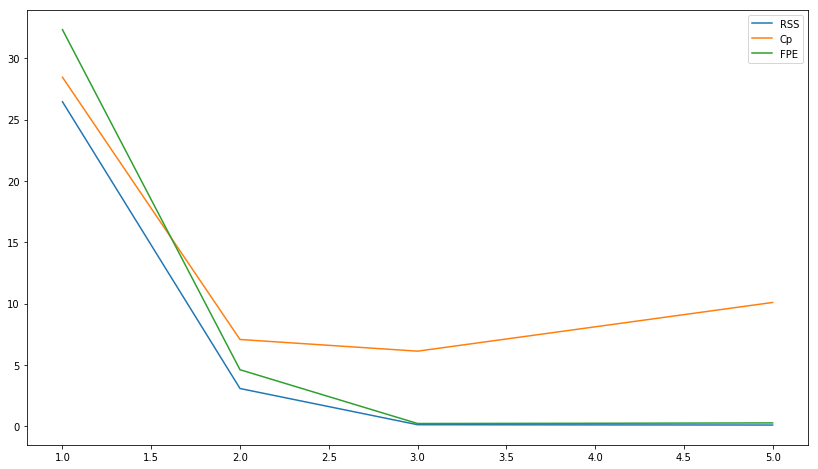

     s        RSS         Cp        FPE
0  1.0  26.460190  28.460190  32.340233
1  2.0   3.066155   7.066155   4.599233
2  3.0   0.113549   6.113549   0.210876
3  4.0   0.098504   8.098504   0.229843
4  5.0   0.086622  10.086622   0.259865
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #2
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.5
X[:10]:
[[0.567172   0.70256042 0.12983461 0.83650689 0.85637431]
 [1.95834886 1.40527645 0.73328716 1.02527044 1.89902809]
 [0.70137114 0.32817463 1.03413801 1.78540143 1.89997852]
 [0.15491019 0.37190304 1.25251242 0.92916547 0.74203965]
 [0.71278449 0.36288905 1.46285576 1.77617648 0.68825604]
 [0.57755351 1.64549734 0.39813699 0.92610897 0.09100372]
 [0.86416482 1.51841146 0.18991905 0.32022759 1.57186908]
 [0.64466693 1.15292789 0.46726247 1.27437158 0.80329334]
 [1.7751452  0.42417773 1.82210455 0.76993118 1.84

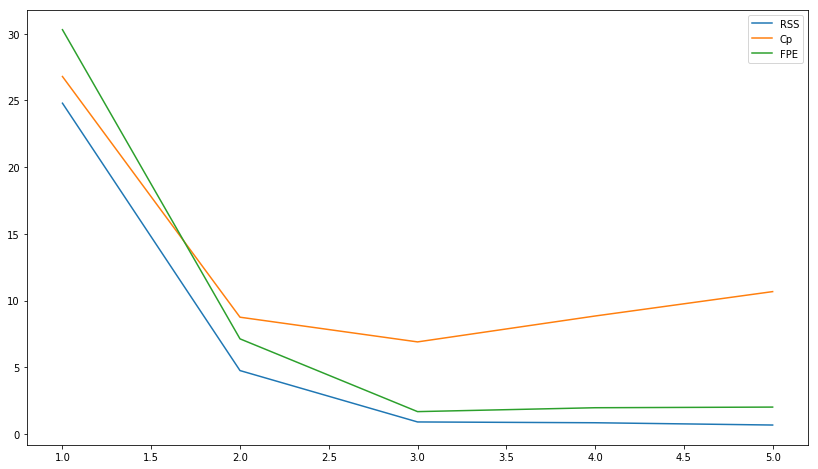

     s        RSS         Cp        FPE
0  1.0  24.792913  26.792913  30.302449
1  2.0   4.754122   8.754122   7.131183
2  3.0   0.903253   6.903253   1.677470
3  4.0   0.843836   8.843836   1.968951
4  5.0   0.672451  10.672451   2.017352
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #3
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 1
X[:10]:
[[0.31005451 1.20802871 1.38032618 0.29664648 1.45565723]
 [0.8213116  1.11577842 0.01574681 1.50619204 0.38500805]
 [0.6944142  0.04185602 0.2064225  0.83418255 1.40875571]
 [0.50270189 1.03553602 1.88949697 0.45671565 0.16750828]
 [0.54758934 0.13199057 0.51348506 1.11634199 0.0277619 ]
 [0.74816734 1.6517793  1.16656544 0.32565901 1.15664489]
 [0.84680588 0.45456503 1.19853061 0.06928066 1.59489734]
 [1.81649233 0.95478532 0.72297216 0.2979181  1.79382744]
 [1.11297429 0.38023323 0.89536585 0.99196534 0.4922

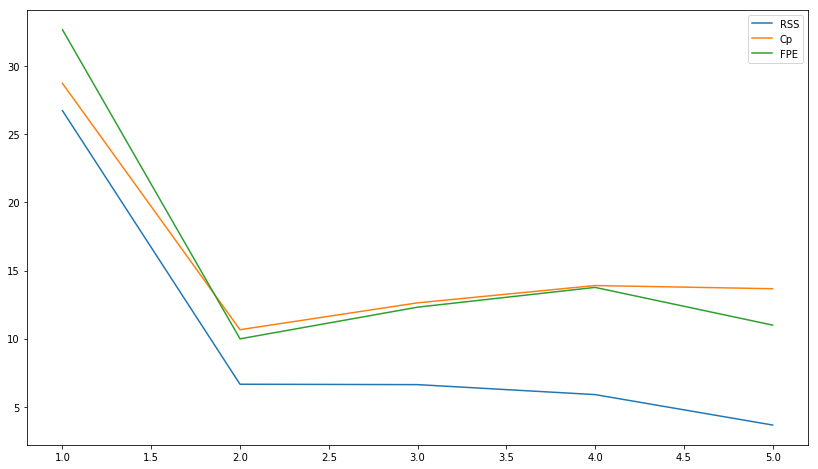

     s        RSS         Cp        FPE
0  1.0  26.727752  28.727752  32.667252
1  2.0   6.658556  10.658556   9.987833
2  3.0   6.629091  12.629091  12.311169
3  4.0   5.897959  13.897959  13.761904
4  5.0   3.665148  13.665148  10.995443
s* by Cp:  2
s* by FPE: 2

--------------------------------------------------------------
			SAMPLE #4
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.1
X[:10]:
[[1.28326898 1.78173104 1.73111289 1.56349277 1.18973762]
 [0.4583317  0.21181446 1.24031403 1.05327378 1.39253156]
 [0.16706865 0.53622089 1.99065273 1.37166276 0.97882675]
 [1.78215751 1.69263088 1.16846892 1.31760039 0.86767538]
 [1.35226375 0.09675905 0.20339146 0.24227113 0.92191264]
 [0.86712672 1.94610479 0.14818311 0.23195804 0.29580928]
 [1.2180066  0.79665595 1.38141413 1.9827386  0.21308411]
 [0.10797386 1.81421811 1.8587605  0.0617739  1.51315883]
 [0.15741629 1.88504982 0.18739795 1.03791101 1.71

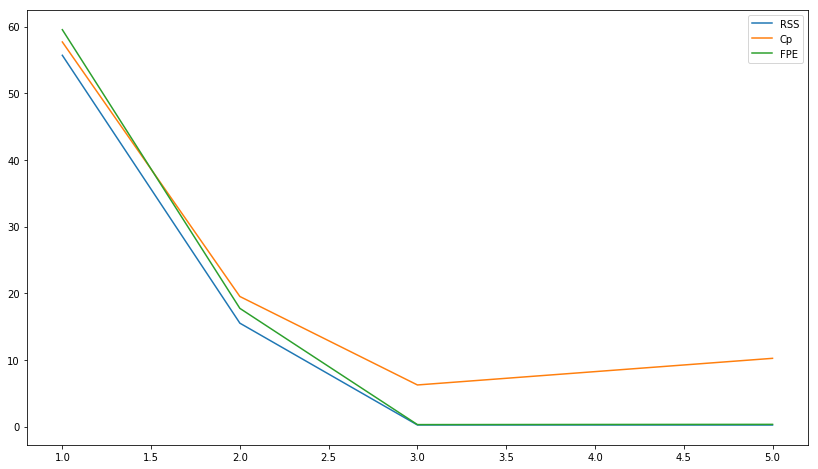

     s        RSS         Cp        FPE
0  1.0  55.682089  57.682089  59.522233
1  2.0  15.523158  19.523158  17.740752
2  3.0   0.260315   6.260315   0.318163
3  4.0   0.259067   8.259067   0.338780
4  5.0   0.252485  10.252485   0.353479
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #5
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.5
X[:10]:
[[1.47339591 1.73939055 0.16122426 1.61092905 1.26579701]
 [0.01134489 0.79879547 1.05443874 0.40341712 0.13198369]
 [1.75365827 1.83066696 1.84116931 0.09045798 1.69875687]
 [1.50960318 0.91572981 1.87216488 0.71951387 0.63733188]
 [1.14327242 0.82299195 1.80738254 0.40962747 0.73510233]
 [1.99259171 0.88244753 1.55759504 0.39471531 0.37288349]
 [1.59096885 0.66313434 0.81581255 1.85293461 0.91097934]
 [0.2705937  0.75975248 1.50435984 0.88333529 0.56584391]
 [1.62109262 1.94862925 1.33398573 1.15640266 1.45

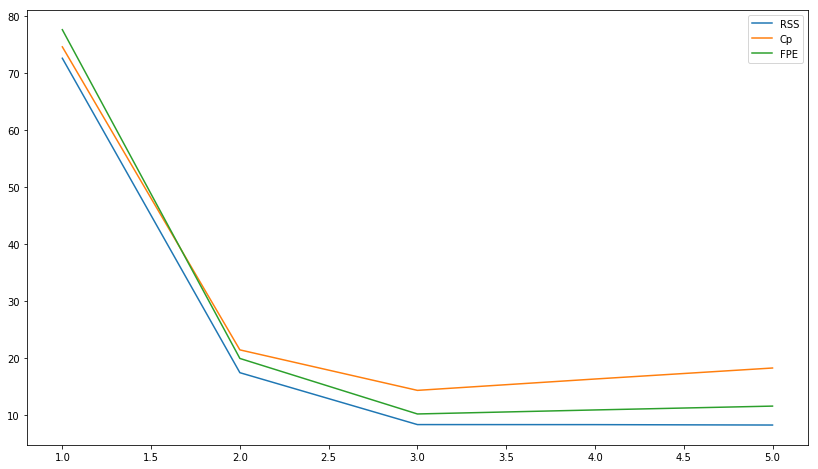

     s        RSS         Cp        FPE
0  1.0  72.619978  74.619978  77.628253
1  2.0  17.479175  21.479175  19.976200
2  3.0   8.377721  14.377721  10.239436
3  4.0   8.369120  16.369120  10.944234
4  5.0   8.299142  18.299142  11.618798
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #6
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 1
X[:10]:
[[1.01487858 0.91550347 1.18561398 0.42092781 0.72680024]
 [1.78570588 0.9488772  0.10748467 1.01995857 0.6170183 ]
 [0.90342959 0.15115503 0.55624806 0.3942357  0.83360686]
 [0.60438226 0.47137403 0.42623758 0.4023114  0.94110593]
 [0.44091572 1.38315137 1.60686652 1.7645299  1.29215315]
 [1.26924652 0.07768314 1.51561014 0.27004516 0.19608779]
 [1.15709896 1.72663758 1.6225514  1.93767321 1.6993186 ]
 [1.63559013 0.06285044 1.67517113 0.30472639 0.54754311]
 [1.27097413 1.97612838 1.68479519 0.18372364 0.0616

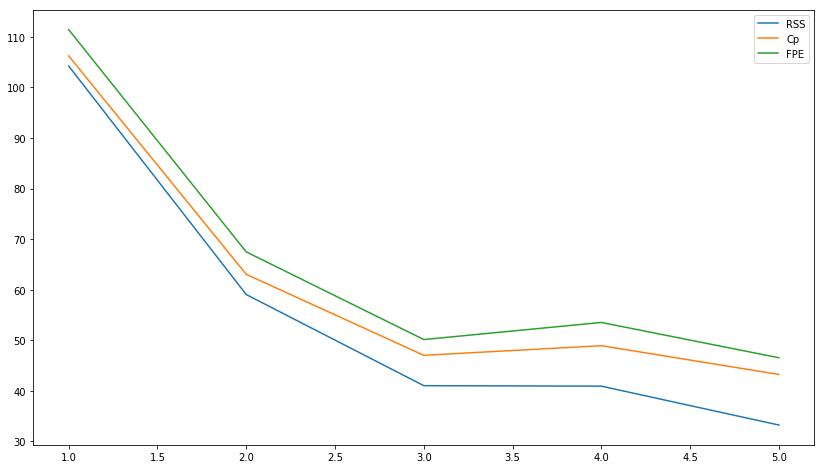

     s         RSS          Cp         FPE
0  1.0  104.226094  106.226094  111.414100
1  2.0   59.045414   63.045414   67.480474
2  3.0   41.032191   47.032191   50.150456
3  4.0   40.934160   48.934160   53.529287
4  5.0   33.248369   43.248369   46.547717
s* by Cp:  5
s* by FPE: 5

--------------------------------------------------------------
			SAMPLE #7
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.1
X[:10]:
[[0.01831272 1.66625113 0.50979772 1.39977338 1.6983301 ]
 [0.56780234 1.02811766 1.18436392 1.02668805 1.01825733]
 [1.46383824 1.09056719 0.39048525 1.47816311 1.08695851]
 [0.02515976 1.12991233 0.76246298 1.8600863  0.11951243]
 [0.28446639 0.72028333 0.31422965 0.05702787 1.17519346]
 [1.00819292 1.39557301 1.73412965 1.93275773 0.79502757]
 [1.40234484 0.63854208 1.40865795 0.65485975 1.64133252]
 [0.66861283 1.46854879 1.24992823 1.12132099 1.03771673]
 [0.69619568 1.34438027 1.41833

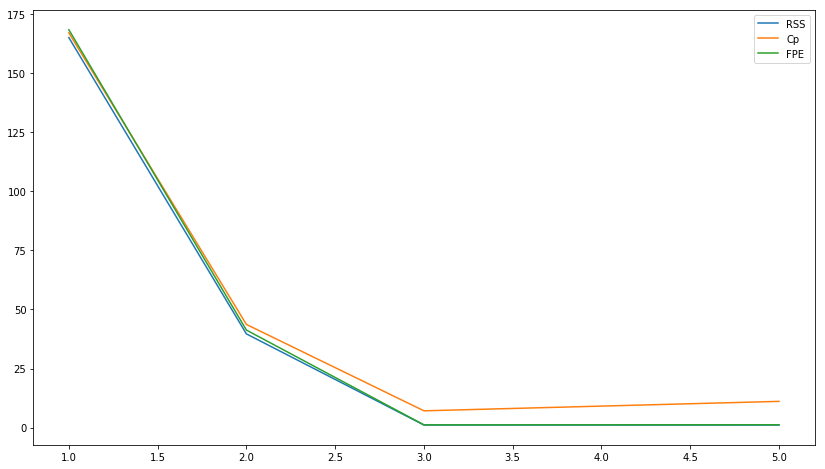

     s         RSS          Cp         FPE
0  1.0  164.936752  166.936752  168.268807
1  2.0   39.663550   43.663550   41.282470
2  3.0    1.134091    7.134091    1.204241
3  4.0    1.130685    9.130685    1.224908
4  5.0    1.125099   11.125099    1.243531
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #8
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.5
X[:10]:
[[0.2386683  1.27085311 1.72558384 0.87401889 0.78273429]
 [1.98642326 1.38736755 1.66496974 0.55665671 0.35647094]
 [0.71156932 0.95562627 0.34546268 0.98704009 1.18107251]
 [1.34214952 1.79071631 0.35727646 0.26283926 0.09394722]
 [1.59242823 1.32864423 1.39957892 0.1093283  1.71844804]
 [0.18434806 0.71459954 0.01430129 1.10300181 1.83972621]
 [0.84038523 0.62837847 1.25599262 1.51076466 1.34592881]
 [1.10375166 0.56474976 0.07941578 0.49288769 1.17562265]
 [1.54001234 1.81172511 1.86984

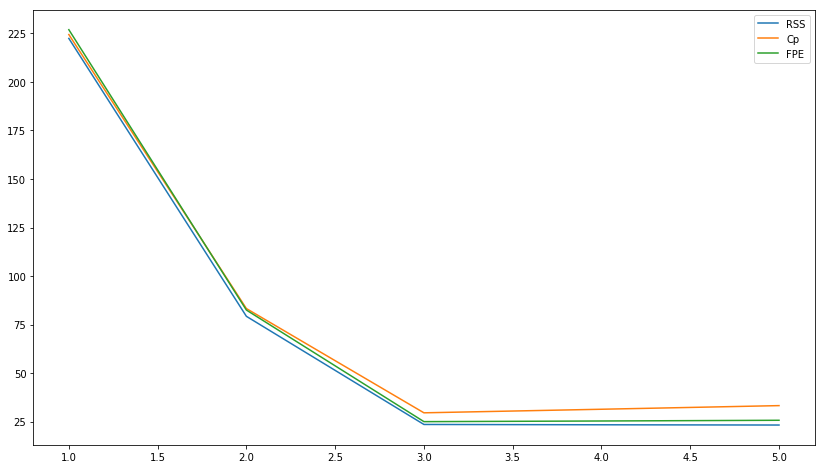

     s         RSS          Cp         FPE
0  1.0  222.417526  224.417526  226.910809
1  2.0   79.269568   83.269568   82.505061
2  3.0   23.562871   29.562871   25.020368
3  4.0   23.400583   31.400583   25.350632
4  5.0   23.271160   33.271160   25.720756
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #9
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 1
X[:10]:
[[1.9354607  0.51960313 0.66374626 1.235595   1.76358799]
 [1.06894498 1.206468   1.62273761 1.03177217 0.1846316 ]
 [1.16064414 0.18065097 1.20907666 0.86960422 0.98256566]
 [1.51717865 0.2839024  0.68714641 1.12773151 0.52663546]
 [1.52255384 1.58038751 0.74659884 0.82893156 1.28668491]
 [0.55964397 1.7021998  1.44512488 1.42186752 1.51618914]
 [1.53319132 0.68872811 1.82287043 1.44712093 1.16062836]
 [1.0468469  0.6888965  0.1122544  1.06856022 0.72097916]
 [1.48766893 0.98324665 0.3514994

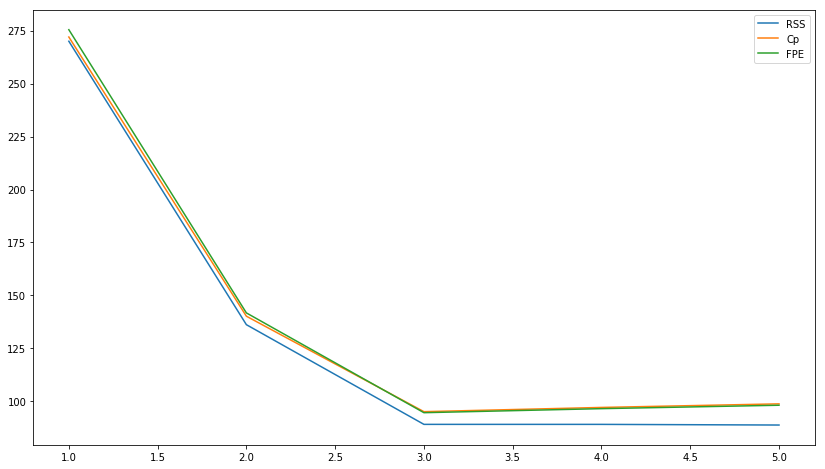

     s         RSS          Cp         FPE
0  1.0  270.023956  272.023956  275.478985
1  2.0  136.193341  140.193341  141.752253
2  3.0   89.124088   95.124088   94.636918
3  4.0   89.118477   97.118477   96.545017
4  5.0   88.808067   98.808067   98.156284
s* by Cp:  3
s* by FPE: 3



In [280]:
config.run_grid_RMNK_model_selection()

In [281]:
config.run_single_full_RMNK_model_selection(sort_values_by=['Cp', 'FPE'])
# ['s', 'Cp', 'FPE']

,s,regressors,RSS,Cp,FPE
0,3.0,"[1, 2, 3]",89.124088,95.124088,94.636918
1,4.0,"[1, 2, 3, 5]",88.829075,96.829075,96.231497
2,4.0,"[1, 2, 3, 4]",89.118477,97.118477,96.545017
3,5.0,"[1, 2, 3, 4, 5]",88.808067,98.808067,98.156284
4,3.0,"[1, 2, 5]",121.455088,127.455088,128.967774
5,4.0,"[1, 2, 4, 5]",120.071111,128.071111,130.077036
6,3.0,"[1, 2, 4]",131.593774,137.593774,139.733595
7,2.0,"[1, 2]",136.193341,140.193341,141.752253
8,3.0,"[1, 3, 4]",257.914953,263.914953,273.868455
9,4.0,"[1, 3, 4, 5]",255.939739,263.939739,277.268051
